In [238]:
import numpy as np
print(np)
%matplotlib nbagg
import matplotlib
from scipy import special
import dedalus.public as de
import numpy as np
import matplotlib.pylab as plt
from eigentools import Eigenproblem

<module 'numpy' from '/Users/susanclark/dedalus_upgraded2/dedalus/lib/python3.5/site-packages/numpy/__init__.py'>


In [218]:
nr1 = 50
r_shortgrid = de.Chebyshev('r', nr1, interval=(1, 2))
d1 = de.Domain([r_shortgrid])

nr2 = nr1*1.5
r_longgrid = de.Chebyshev('r', nr2, interval=(1, 2))
d2 = de.Domain([r_longgrid])

In [219]:
Q = 0.01269
Rm = 0.67355
Pm = 1.0e-3
beta = 25.0
Omega1 = 313.55
Omega2 = 56.43
xi = 0
R1 = 5
R2 = 15

Re = Rm/Pm
iRm = 1.0/Rm
iR = 1.0/Re

c1 = (Omega2*R2**2 - Omega1*R1**2)/(R2**2 - R1**2)
c2 = (R1**2*R2**2*(Omega1 - Omega2))/(R2**2 - R1**2)

In [220]:
test1 = de.EVP(d1,['psi', 'u', 'A', 'B', 'psir', 'ur', 'Ar', 'Br', 'psirr', 'psirrr'],'sigma')
test1_2 = de.EVP(d2,['psi','u', 'A', 'B', 'psir', 'psirr', 'psirrr', 'ur', 'Ar', 'Br'],'sigma')

2016-08-11 00:41:09,931 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10
2016-08-11 00:41:09,933 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10


In [221]:
# let's just test L0
test1.parameters['iRm'] = 0.5
test1.parameters['iR'] = 0.3
test1.add_equation("r**4*sigma*psi - iR*(-3*psir + r*3*psirr - 2*r**2*psirrr + r**3*dr(psirrr)) = 0")
test1.add_equation("r**2*sigma*u - iR*(r**2*dr(ur) + r*ur - u) = 0")
test1.add_equation("r*sigma*A - iRm*(r*dr(Ar) - Ar) = 0")
test1.add_equation("r**2*sigma*B - iRm*(r**2*dr(Br) + r*Br - B) = 0")
test1.add_equation("dr(psi) - psir = 0")
test1.add_equation("dr(psir) - psirr = 0")
test1.add_equation("dr(psirr) - psirrr = 0")
test1.add_equation("dr(u) - ur = 0")
test1.add_equation("dr(A) - Ar = 0")
test1.add_equation("dr(B) - Br = 0")

test1.add_bc('left(u) = 0')
test1.add_bc('right(u) = 0')
test1.add_bc('left(psi) = 0')
test1.add_bc('right(psi) = 0')
test1.add_bc('left(psi + r*psir) = 0')
test1.add_bc('right(psi + r*psir) = 0')
test1.add_bc('left(A) = 0')
test1.add_bc('right(A) = 0')
test1.add_bc('left(B + r*Br) = 0')
test1.add_bc('right(B + r*Br) = 0')

In [222]:
test_solver1 = test1.build_solver()
test_solver1.solve(test_solver1.pencils[0])


/Users/susanclark/dedalus_upgraded2/dedalus/lib/python3.5/site-packages/scipy/linalg/decomp.py:56: RuntimeWarning: divide by zero encountered in true_divide
  w = alpha / beta
/Users/susanclark/dedalus_upgraded2/dedalus/lib/python3.5/site-packages/scipy/linalg/decomp.py:56: RuntimeWarning: invalid value encountered in true_divide
  w = alpha / beta


In [223]:
ev1 = test_solver1.eigenvalues

<IPython.core.display.Javascript object>


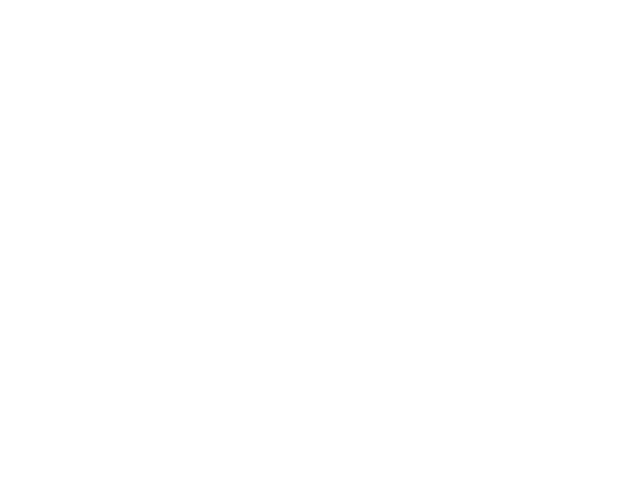

In [224]:

plt.plot(ev1.real, ev1.imag, '+')

In [225]:
ev1

masked_array(data = [-- (59970565296.713905+0j) (16110384029.735659+0j) (4834916811.653657+0j)
 (2606404429.0140705+0j) (944969149.0101255+0j) (614339452.5417104+0j)
 (326068029.34262246+0j) (241227602.43260008+0j) (141763897.24481508+0j)
 (108753963.73640068+0j) (74872295.80992983+0j) (59207161.506518535+0j)
 (44118581.01651297+0j) (35970926.16339247+0j) (28844144.69382013+0j)
 (23949914.566019498+0j) (20294611.164896436+0j) (17437371.671681773+0j)
 (15049960.390109723+0j) (13037598.845898082+0j) (11309719.914605+0j)
 (9749109.506381154+0j) (8355640.069511806+0j) (7120225.618913692+0j)
 (6027270.50201156+0j) (5064973.003372871+0j) (4222790.3864500895+0j)
 (3490293.576921797+0j) (2857496.109036096+0j) (2314912.477382485+0j)
 (1853533.7613565924+0j) (1464822.1194528178+0j) (1140714.2059841023+0j)
 (873621.2589490294+0j) (656428.8259904525+0j) (482496.68471635197+0j)
 (345658.9394675223+0j) (240223.99556250675+0j) (160974.55105023118+0j)
 (103167.60714922813+0j) (62534.46494439406+0j) (3

In [226]:
# L0 adjoint...
test1adj = de.EVP(d1,['psi', 'u', 'A', 'B', 'psir', 'ur', 'Ar', 'Br', 'psirr', 'psirrr'],'sigma')
test1adj.parameters['iRm'] = 0.5
test1adj.parameters['iR'] = 0.3
test1adj.add_equation("r**4*sigma*psi - iR*(-3*psir - r*9*psirr + 6*r**2*psirrr - r**3*dr(psirrr)) = 0")
test1adj.add_equation("r*sigma*u - iR*(r*dr(ur) - ur) = 0")
test1adj.add_equation("r**2*sigma*A - iRm*(r**2*dr(Ar) + r*Ar - A) = 0")
test1adj.add_equation("r*sigma*B - iRm*(r*dr(Br) - Br) = 0")
test1adj.add_equation("dr(psi) - psir = 0")
test1adj.add_equation("dr(psir) - psirr = 0")
test1adj.add_equation("dr(psirr) - psirrr = 0")
test1adj.add_equation("dr(u) - ur = 0")
test1adj.add_equation("dr(A) - Ar = 0")
test1adj.add_equation("dr(B) - Br = 0")

test1adj.add_bc('left(u) = 0')
test1adj.add_bc('right(u) = 0')
test1adj.add_bc('left(psi) = 0')
test1adj.add_bc('right(psi) = 0')
test1adj.add_bc('left(psi + r*psir) = 0')
test1adj.add_bc('right(psi + r*psir) = 0')
test1adj.add_bc('left(A) = 0')
test1adj.add_bc('right(A) = 0')
test1adj.add_bc('left(B + r*Br) = 0')
test1adj.add_bc('right(B + r*Br) = 0')

2016-08-11 00:41:13,849 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10


In [227]:
testadj_solver1 = test1adj.build_solver()
testadj_solver1.solve(testadj_solver1.pencils[0])

ev1adj = testadj_solver1.eigenvalues

/Users/susanclark/dedalus_upgraded2/dedalus/lib/python3.5/site-packages/scipy/linalg/decomp.py:56: RuntimeWarning: divide by zero encountered in true_divide
  w = alpha / beta
/Users/susanclark/dedalus_upgraded2/dedalus/lib/python3.5/site-packages/scipy/linalg/decomp.py:56: RuntimeWarning: invalid value encountered in true_divide
  w = alpha / beta


<IPython.core.display.Javascript object>


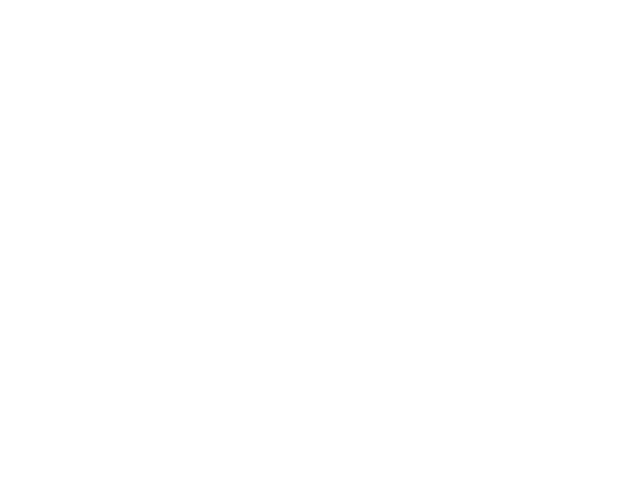

In [228]:
fig = plt.figure()
plt.plot(ev1adj.real, ev1adj.imag, '+')
plt.plot(-ev1.real, -ev1.imag, '+')

In [229]:
lv1 = de.EVP(d1,
         ['psi','u', 'A', 'B', 'psir', 'psirr', 'psirrr', 'ur', 'Ar', 'Br'],'sigma')

lv1.parameters['Q'] = Q
lv1.parameters['iR'] = iR
lv1.parameters['iRm'] = iRm
lv1.parameters['xi'] = xi
lv1.parameters['beta'] = beta
lv1.parameters['c1'] = c1
lv1.parameters['c2'] = c2
lv1.parameters['B0'] = 1
lv1.parameters['dz'] = 1j*Q

lv1.substitutions['ru0'] = '(r*r*c1 + c2)' # u0 = r Omega(r) = Ar + B/r
lv1.substitutions['rrdu0'] = '(c1*r*r-c2)' # du0/dr = A - B/r^2
lv1.substitutions['twooverbeta'] = '(2.0/beta)'

lv1.substitutions['psivisc'] = '(2*r**2*Q**2*psir - 2*r**3*Q**2*psirr + r**3*Q**4*psi + r**3*dr(psirrr) - 3*psir + 3*r*psirr - 2*r**2*psirrr)'
lv1.substitutions['uvisc'] = '(-r**3*Q**2*u + r**3*dr(ur) + r**2*ur - r*u)'
lv1.substitutions['Avisc'] = '(r*dr(Ar) - r*Q**2*A - Ar)' 
lv1.substitutions['Bvisc'] = '(-r**3*Q**2*B + r**3*dr(Br) + r**2*Br - r*B)'

lv1.add_equation("sigma*(-r**3*Q**2*psi + r**3*psirr - r**2*psir) - r**2*2*ru0*1j*Q*u + r**3*twooverbeta*B0*1j*Q**3*A + twooverbeta*B0*r**2*1j*Q*Ar - twooverbeta*r**3*B0*1j*Q*dr(Ar) - iR*psivisc + twooverbeta*r**2*2*xi*1j*Q*B = 0") #corrected on whiteboard 5/6
lv1.add_equation("sigma*r**3*u + 1j*Q*ru0*psi + 1j*Q*rrdu0*psi - 1j*Q*r**3*twooverbeta*B0*B - iR*uvisc = 0") 
lv1.add_equation("sigma*r*A - r*B0*1j*Q*psi - iRm*Avisc = 0")
lv1.add_equation("sigma*r**3*B + ru0*1j*Q*A - r**3*B0*1j*Q*u - 1j*Q*rrdu0*A - iRm*Bvisc - 2*xi*1j*Q*psi = 0") 

lv1.add_equation("dr(psi) - psir = 0")
lv1.add_equation("dr(psir) - psirr = 0")
lv1.add_equation("dr(psirr) - psirrr = 0")
lv1.add_equation("dr(u) - ur = 0")
lv1.add_equation("dr(A) - Ar = 0")
lv1.add_equation("dr(B) - Br = 0")

lv1.add_bc('left(u) = 0')
lv1.add_bc('right(u) = 0')
lv1.add_bc('left(psi) = 0')
lv1.add_bc('right(psi) = 0')
lv1.add_bc('left(psi + r*psir) = 0')
lv1.add_bc('right(psi + r*psir) = 0')
lv1.add_bc('left(A) = 0')
lv1.add_bc('right(A) = 0')
lv1.add_bc('left(B + r*Br) = 0')
lv1.add_bc('right(B + r*Br) = 0')

2016-08-11 00:41:18,011 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10


In [230]:
#ordere = lv1.build_solver()
#ordere.solve(ordere.pencils[0])

#evals_ordere = ordere.eigenvalues
EPordere = Eigenproblem(lv1)
EPordere.solve()
EPordere.reject_spurious()
evals_ordere = EPordere.evalues_good


2016-08-11 00:41:23,496 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10


/Users/susanclark/dedalus_upgraded2/dedalus/lib/python3.5/site-packages/scipy/linalg/decomp.py:56: RuntimeWarning: divide by zero encountered in true_divide
  w = alpha / beta
/Users/susanclark/dedalus_upgraded2/dedalus/lib/python3.5/site-packages/scipy/linalg/decomp.py:56: RuntimeWarning: invalid value encountered in true_divide
  w = alpha / beta
/Users/susanclark/eigentools/eigentools/eigenproblem.py:183: ComplexWarning: Casting complex values to real discards the imaginary part
  indx = lambda1_and_indx[:, 1].astype(np.int)


<IPython.core.display.Javascript object>


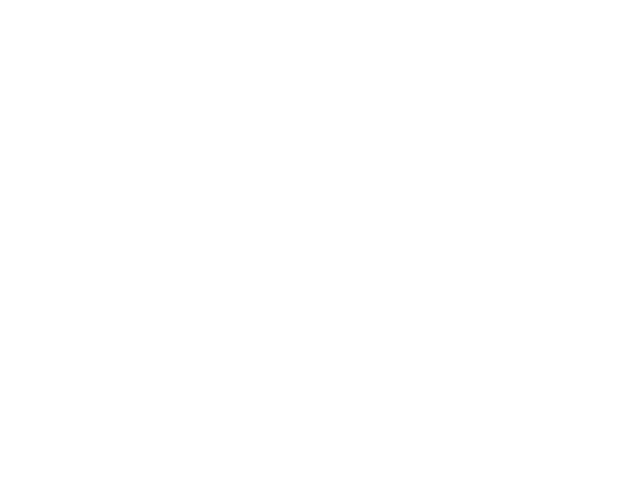

In [231]:
fig = plt.figure()
plt.plot(ev1.real, ev1adj.real, '.')

The following is the old adjoint, currently in allorders2_widegap

In [233]:
adjold = de.EVP(d1,
         ['psi','u', 'A', 'B', 'psir', 'psirr', 'psirrr', 'ur', 'Ar', 'Br'],'sigma')

adjold.parameters['Q'] = Q
adjold.parameters['iR'] = iR
adjold.parameters['iRm'] = iRm
adjold.parameters['xi'] = xi
adjold.parameters['beta'] = beta
adjold.parameters['c1'] = c1
adjold.parameters['c2'] = c2
adjold.parameters['B0'] = 1
adjold.parameters['dz'] = 1j*Q

adjold.substitutions['ru0'] = '(r*r*c1 + c2)' # u0 = r Omega(r) = Ar + B/r
adjold.substitutions['rrdu0'] = '(c1*r*r-c2)' # du0/dr = A - B/r^2
adjold.substitutions['twooverbeta'] = '(2.0/beta)'

# multiply by [r^4, r^2, r^3, r^2]
adjold.add_equation("sigma*(-r**3*Q**2*psi + r**3*psirr - r**2*psir) - r*1j*Q*rrdu0*u - r*ru0*1j*Q*u + r**4*1j*Q*A - iR*r**3*Q**4*psi + iR*r**3*2*Q**2*psirr - iR*r**2*2*Q**2*psir - iR*r**3*dr(psirrr) + iR*r**2*2*psirrr - iR*r*3*psirr + iR*3*psir + r*2*1j*Q*B0*xi*B = 0")
adjold.add_equation("sigma*r**2*u + 1j*Q*r**2*B + 2*1j*Q*ru0*psi + iR*Q**2*r**2*u - iR*r**2*dr(ur) -iR*r*ur + iR*u = 0")
adjold.add_equation("sigma*r**3*A + rrdu0*1j*Q*B - ru0*1j*Q*B - twooverbeta*r**2*1j*Q**3*psi + twooverbeta*r**2*1j*Q*psirr - twooverbeta*r*1j*Q*psir + iRm*r**3*Q**2*A - iRm*r**3*dr(Ar) + iRm*r**2*Ar = 0")
adjold.add_equation("sigma*r**2*B + r**2*twooverbeta*1j*Q*u + r**2*iRm*Q**2*B - r**2*iRm*dr(Br) - iRm*r*Br + iRm*B - twooverbeta*2*1j*Q*B0*xi*psi = 0") 

adjold.add_equation("dr(psi) - psir = 0")
adjold.add_equation("dr(psir) - psirr = 0")
adjold.add_equation("dr(psirr) - psirrr = 0")
adjold.add_equation("dr(u) - ur = 0")
adjold.add_equation("dr(A) - Ar = 0")
adjold.add_equation("dr(B) - Br = 0")

adjold.add_bc('left(u) = 0')
adjold.add_bc('right(u) = 0')
adjold.add_bc('left(psi) = 0')
adjold.add_bc('right(psi) = 0')
adjold.add_bc('left(psir) = 0')
adjold.add_bc('right(psir) = 0')
adjold.add_bc('left(A) = 0')
adjold.add_bc('right(A) = 0')
adjold.add_bc('left(B + r*Br) = 0')
adjold.add_bc('right(B + r*Br) = 0') # axial component of current = 0

EPadjold = Eigenproblem(adjold)

#adjprob = adjold.build_solver()
#adjprob.solve(adjprob.pencils[0])

#evals_oldadj = adjprob.eigenvalues

EPadjold.solve()
EPadjold.reject_spurious()
evals_oldadj = EPadjold.evalues_good

2016-08-11 00:44:56,441 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10
2016-08-11 00:45:01,222 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10


/Users/susanclark/dedalus_upgraded2/dedalus/lib/python3.5/site-packages/scipy/linalg/decomp.py:56: RuntimeWarning: divide by zero encountered in true_divide
  w = alpha / beta
/Users/susanclark/dedalus_upgraded2/dedalus/lib/python3.5/site-packages/scipy/linalg/decomp.py:56: RuntimeWarning: invalid value encountered in true_divide
  w = alpha / beta
/Users/susanclark/eigentools/eigentools/eigenproblem.py:183: ComplexWarning: Casting complex values to real discards the imaginary part
  indx = lambda1_and_indx[:, 1].astype(np.int)


<IPython.core.display.Javascript object>


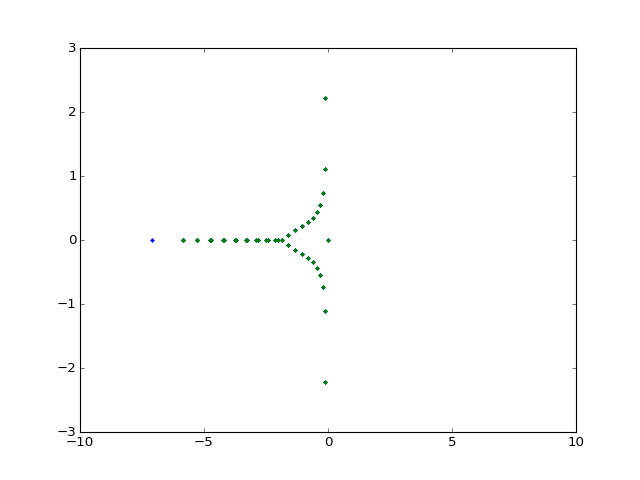

(-10, 10)

In [234]:
plt.figure()
plt.plot(evals_oldadj.real, evals_oldadj.imag, '.')
plt.plot(evals_ordere.real, evals_ordere.imag, '.')
plt.xlim(-10, 10)

<IPython.core.display.Javascript object>


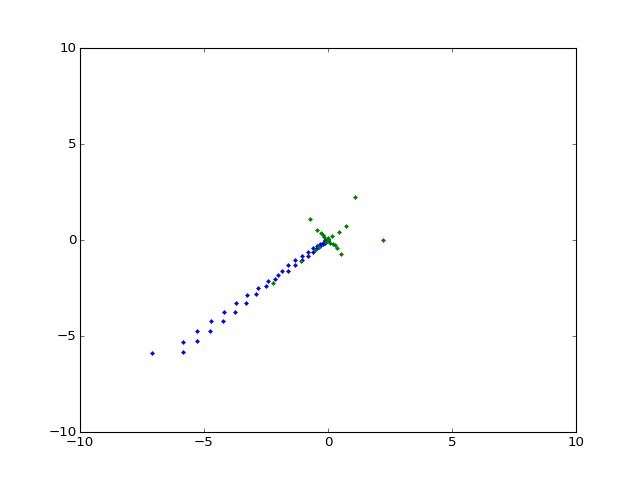

83 82


(-10, 10)

In [235]:
plt.figure()
print(len(evals_oldadj), len(evals_ordere))
plt.plot(evals_oldadj[:-1].real, evals_ordere.real, '.')
plt.plot(evals_oldadj[:-1].imag, evals_ordere.imag, '.')
plt.xlim(-10, 10)
plt.ylim(-10, 10)

Number of positive real parts 143


<IPython.core.display.Javascript object>


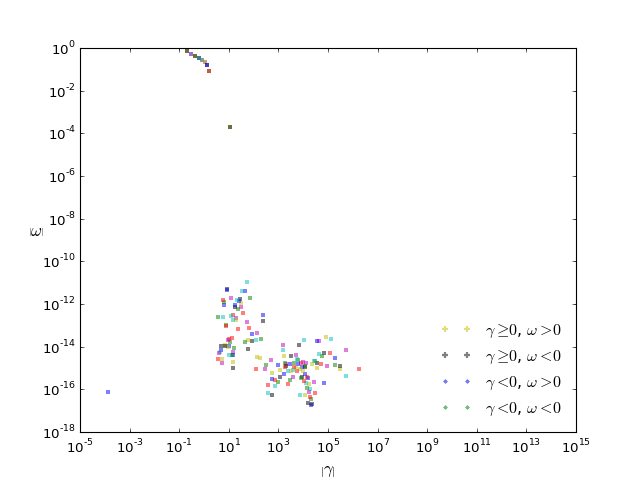

In [239]:
EPadjold.spectrum()

Number of positive real parts 144


<IPython.core.display.Javascript object>


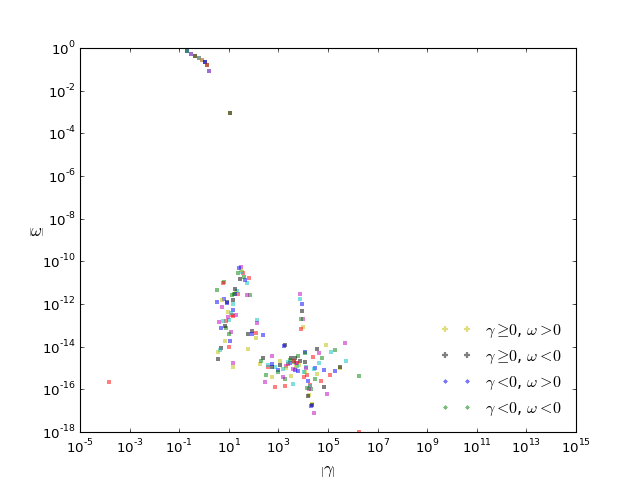

In [240]:
EPordere.spectrum()